# 0. Description and Overview

This is a Proof of Concept (POC) project evaluating the output & performance of a Neural Network (NN) for a small-sized insurance company. We want to prove that applying Data Science principles and deep learning models can provide value to all types of businesses, even small business with limited dataset. 

We leverage a real-case data from Texas Giant Insurance (TGI). TGI focuses on providing commercial and personal insurance programs to its clients. TGI is an independent insurance company with an in-depth knowledge of multiple insurance products and carriers. They proactively provide many services to their policyholders.

We evaluated three models and showed that the deep learning model is the most accurate, even with the limited features and a small dataset. We will look at accuracy though, it may be argued that F1 Score may be more relevant:
<ol>
<li>Supervised Learning (Logistic Regression) Model: 73.9%</li>
<li>Baseline Single-Layered NN: 69.4%</li>
<li>Bayesian Optimized Deep Learning NN: 77.8% (F1 Score: 84.6%)</li>
</ol>

We are pleased to report the following:
<ol>
<li>Two customers who are no longer TGI customers said they would be interested in coming back but are price sensitive. </li>
<li>Two customers who are no longer TGI customers are interested in returning; though, TGI may prefer not for them to come back.</li>
<li>One customer who is still a customer asked for a quote to another line of insurance products (automobile). This was a pleasant surprise and may provide future up-selling opportunities. </li>
<li>The client confirmed the robustness of the model that they suggested using this model monthly to identify and prioritize existing customers and potential customers that would return to the company. </li>
</ol>

*Note: The Customer IDs have been modified to preserve customer privacy.

# 1. Load Libraries

In [1]:
# Import libraries for data processing.
import numpy as np
import pandas as pd
import warnings
import time
warnings.filterwarnings('ignore')

# Import Tensorflow and Keras Libraries.
import tensorflow
from tensorflow.python.keras import backend as K
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, LeakyReLU
from keras.optimizers import Adam

# Import sklearn libraries for data processing.
import sklearn
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import fbeta_score
from sklearn.metrics import classification_report
from sklearn.utils import class_weight

Using TensorFlow backend.


In [2]:
# Install and import Pycaret library for transformation and classification.
# !pip install pycaret
from pycaret.classification import *

In [3]:
# Installing the latest recent version of skopt directly from Github
# !pip install scikit-optimize

# Install and import Scikit Optimize library for Bayesian optimization using Gaussian Processes
from skopt import gbrt_minimize, gp_minimize
from skopt.utils import use_named_args
from skopt.space import Real, Categorical, Integer
from skopt.plots import plot_convergence
from skopt.plots import plot_objective
from skopt import dump, load

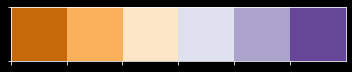

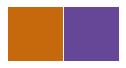

In [4]:
# Import libraries for visualization and set default values.
import matplotlib.pyplot as plt
import seaborn as sns
sns.palplot(sns.color_palette("PuOr"))
pal = sns.color_palette('PuOr', 6)
pal.as_hex()
plt.style.use(['seaborn'])
sns_colors = ["#c6690c", "#664697"]
sns.set_palette(sns_colors)
sns.palplot(sns.color_palette(sns_colors))

# 2. Load Dataset

In [5]:
# Load Dataset.
url = 'https://raw.githubusercontent.com/aliagowani/Deep_Learning_Customer_Classification/master/Data_Insurance_TGI.csv'
dataset = pd.read_csv(url)

In [6]:
# Check shape of dataset and view first 10 observations.
print(dataset.shape)
dataset.head(5)

(713, 30)


,Customer_ID,Gender,Referrer,State,PaidFullPremiumBefore,BecameCust,DurationAsCust,Accident/Health_(P)_Duration,Accident/Health_(P)_Amount,Builders_Risk_(P)_Duration,...,Life_(P)_Amount,Motorcycle_Duration,Motorcycle_Amount,Private_Passenger_Auto_Duration,Private_Passenger_Auto_Amount,Umbrella_(P)_Duration,Umbrella_(P)_Amount,Total_Duration,Total_Amount,StillCustomer
0,786258,M,None,TX,1,1,48,0,0.0,0,...,0.0,0,0,12,6087.15,0,0,60,11011.15,1
1,786063,M,None,TX,1,1,59,0,0.0,0,...,0.0,0,0,0,0.00,0,0,48,4803.00,1
2,786101,M,None,TX,1,1,51,0,0.0,0,...,0.0,0,0,51,15282.00,0,0,75,17954.00,1
3,786217,M,None,TX,1,1,48,0,0.0,0,...,0.0,0,0,48,40597.26,0,0,95,54403.26,1
4,786642,F,None,TX,1,1,47,0,0.0,0,...,0.0,0,0,12,888.00,0,0,59,3003.00,1


# 3. Exploratory Data Analysis (EDA)

In [7]:
# Describe the features in the dataset, such as, count, mean, standard deviation, min, max, etc.
dataset.describe().round(2)

,Customer_ID,PaidFullPremiumBefore,BecameCust,DurationAsCust,Accident/Health_(P)_Duration,Accident/Health_(P)_Amount,Builders_Risk_(P)_Duration,Builders_Risk_(P)_Amount,Dwelling_Fire_Duration,Dwelling_Fire_Amount,...,Life_(P)_Amount,Motorcycle_Duration,Motorcycle_Amount,Private_Passenger_Auto_Duration,Private_Passenger_Auto_Amount,Umbrella_(P)_Duration,Umbrella_(P)_Amount,Total_Duration,Total_Amount,StillCustomer
count,713.00,713.00,713.0,713.00,713.00,713.00,713.00,713.00,713.00,713.00,...,713.00,713.00,713.00,713.00,713.00,713.00,713.00,713.00,713.00,713.00
mean,786390.13,0.51,1.0,30.89,0.04,0.13,0.03,3.58,1.79,281.97,...,7.33,0.02,0.65,16.71,3829.24,0.32,12.09,37.21,6171.38,0.63
std,227.29,0.50,0.0,16.55,0.97,3.38,0.50,81.99,7.39,1463.43,...,132.45,0.45,17.45,18.21,5874.02,3.32,137.25,29.92,7654.71,0.48
min,786000.00,0.00,1.0,3.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,3.00,81.00,0.00
25%,786186.00,0.00,1.0,12.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,12.00,1385.00,0.00
50%,786383.00,1.00,1.0,30.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,12.00,1578.00,0.00,0.00,24.00,3290.00,1.00
75%,786592.00,1.00,1.0,48.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,30.00,5149.77,0.00,0.00,48.00,8006.91,1.00
max,786786.00,1.00,1.0,69.00,26.00,90.32,12.00,2153.00,56.00,18478.92,...,3295.00,12.00,466.00,66.00,45661.82,48.00,2490.00,163.00,60330.92,1.00


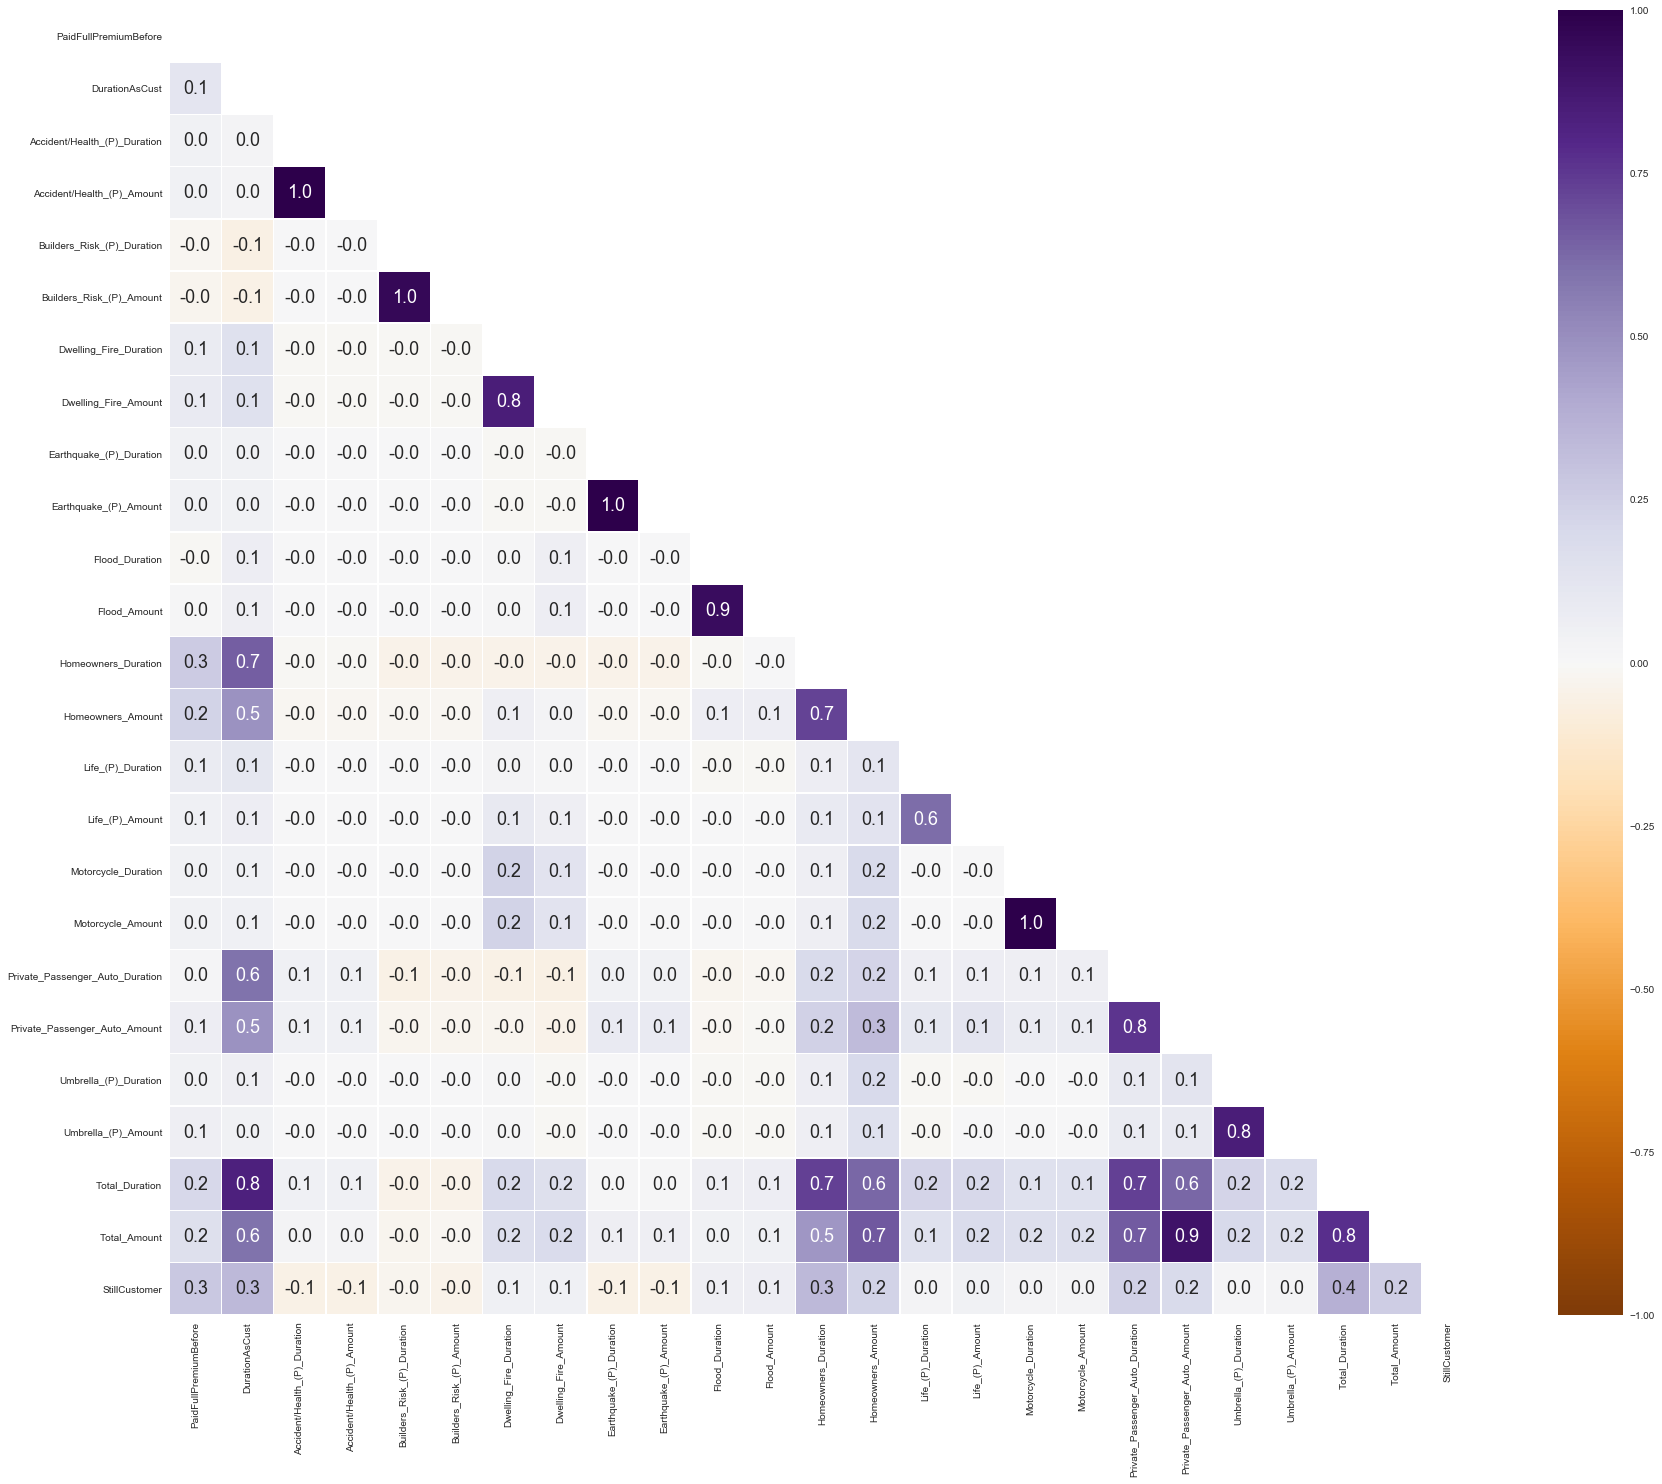

In [8]:
# Create a correlation for the dataset.
dataset_corr = dataset.corr().round(4)

# Drop Customer ID and Became Customer from correlation dataset.
dataset_corr = dataset_corr.drop(["Customer_ID","BecameCust"], axis=1)
dataset_corr = dataset_corr.drop(["Customer_ID","BecameCust"], axis=0)

# Create a correlation matrix. Only bottom left corner valued. 
mask = np.zeros_like(dataset_corr.round(4))
mask[np.triu_indices_from(mask)] = True

with sns.axes_style("whitegrid"):
    f, ax = plt.subplots(figsize=(30, 24))
    ax = sns.heatmap(dataset_corr.round(2), mask=mask, vmax=1, center = 0, vmin=-1, square=True, cmap='PuOr', linewidths=.5, annot=True, annot_kws={"size": 18}, fmt='.1f', )
plt.show()


Not a Customer:  265
Still a Customer:  448
Total:  713



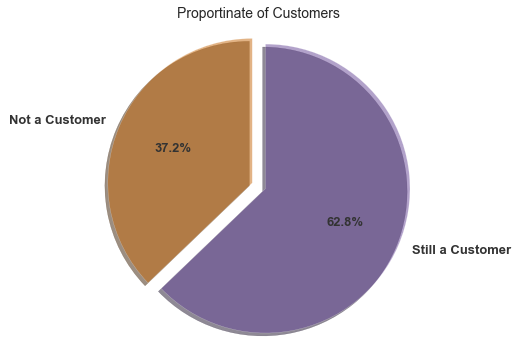

In [9]:
# Count those who are still a customer and not a customer.
not_customer = dataset.StillCustomer[dataset['StillCustomer'] == 0].count()
still_customer = dataset.StillCustomer[dataset['StillCustomer'] == 1].count()
print()
print('Not a Customer: ', not_customer)
print('Still a Customer: ', still_customer)
print('Total: ', not_customer + still_customer)
print()

# Create a plot to visualize the proportionate customers who are still a customer versus not a customer
with sns.axes_style("whitegrid"):
    labels = 'Not a Customer', 'Still a Customer'
    sizes = [dataset.StillCustomer[dataset['StillCustomer'] == 0].count(), dataset.StillCustomer[dataset['StillCustomer'] == 1].count()]
    explode = (0, 0.1)
    fig1, ax1 = plt.subplots(figsize = (9, 6))
    ax1.pie(sizes, explode = explode, labels = labels, autopct = '%1.1f%%', shadow = True, startangle = 90, textprops = {'fontsize': 13, 'weight': 'bold', 'color': '#333333'}, wedgeprops={'alpha':0.5})
    ax1.axis('equal')
    plt.title('Proportinate of Customers', size = 14)
plt.show()

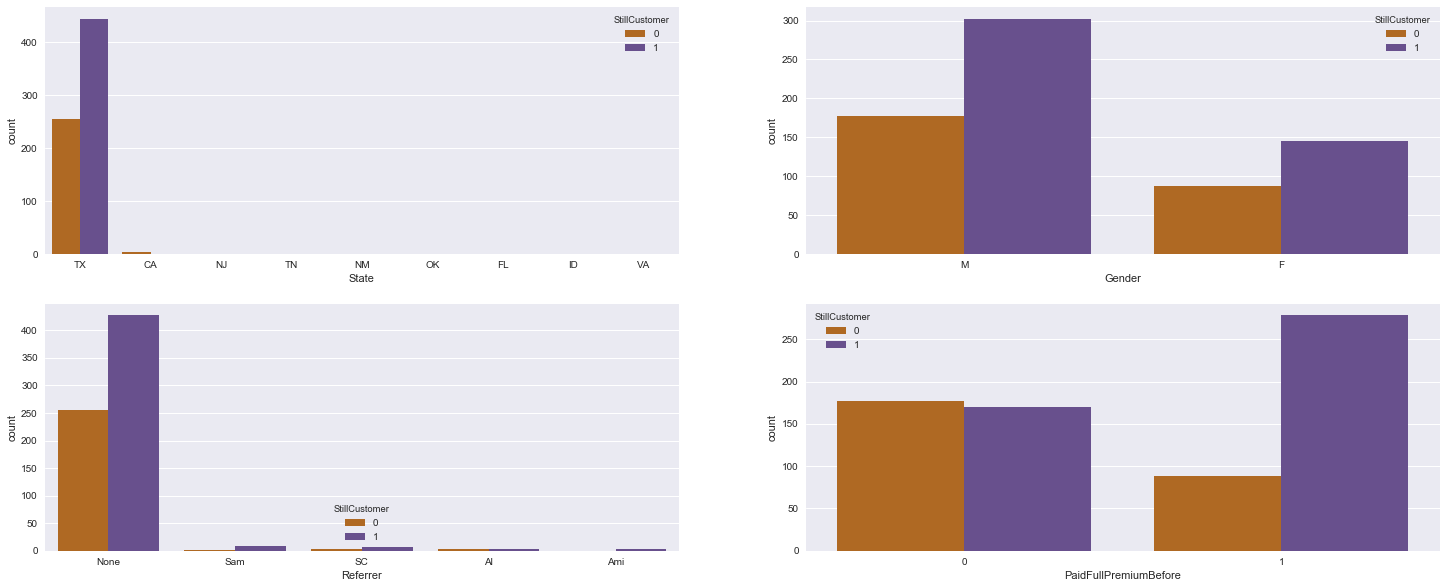

In [10]:
# Visualize label with relevant features
fig, axarr = plt.subplots(2, 2, figsize=(25, 10))
sns.countplot(x='State', hue='StillCustomer', data=dataset, ax=axarr[0][0])
sns.countplot(x='Gender', hue='StillCustomer', data=dataset, ax=axarr[0][1])
sns.countplot(x='Referrer', hue='StillCustomer', data=dataset, ax=axarr[1][0])
sns.countplot(x='PaidFullPremiumBefore', hue='StillCustomer', data=dataset, ax=axarr[1][1])

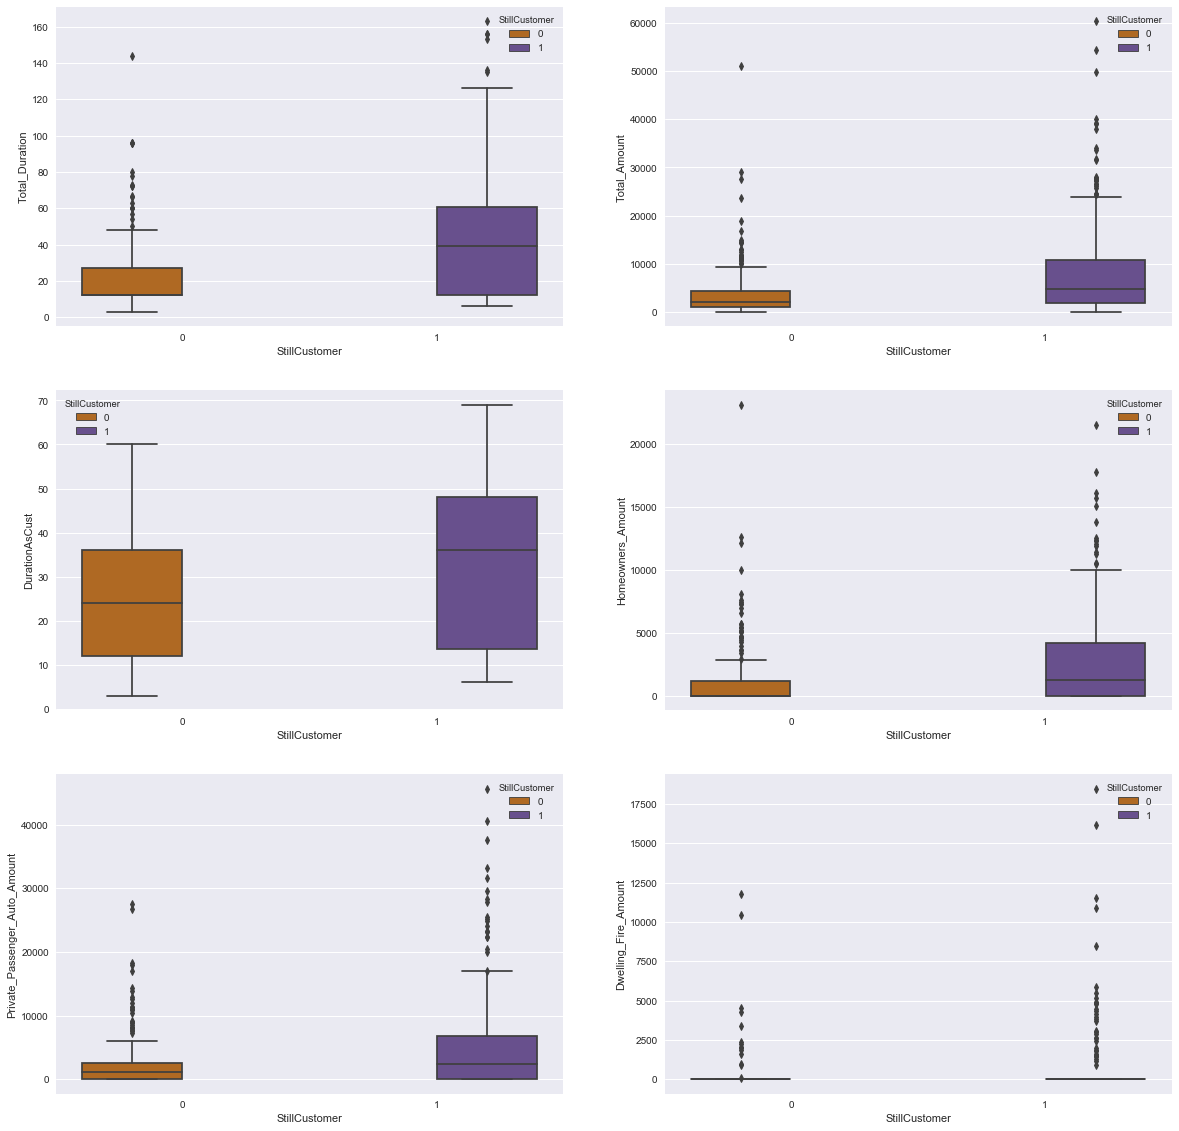

In [11]:
# Visualize box plots of numeric features and compare it with customers
fig, axarr = plt.subplots(3, 2, figsize=(20, 20))
sns.boxplot(y='Total_Duration', x='StillCustomer', hue='StillCustomer', data=dataset, ax=axarr[0][0])
sns.boxplot(y = 'Total_Amount', x = 'StillCustomer', hue = 'StillCustomer', data = dataset , ax = axarr[0][1])
sns.boxplot(y = 'DurationAsCust', x = 'StillCustomer', hue = 'StillCustomer', data = dataset, ax = axarr[1][0])
sns.boxplot(y = 'Homeowners_Amount', x = 'StillCustomer', hue = 'StillCustomer', data = dataset, ax = axarr[1][1])
sns.boxplot(y = 'Private_Passenger_Auto_Amount', x = 'StillCustomer', hue = 'StillCustomer', data = dataset, ax = axarr[2][0])
sns.boxplot(y='Dwelling_Fire_Amount', x='StillCustomer', hue='StillCustomer', data=dataset, ax=axarr[2][1])

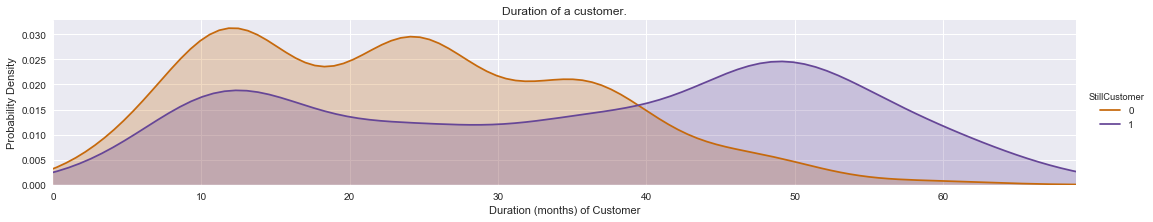

In [12]:
# Visualize the duration of a customer feature to the label
facet = sns.FacetGrid(dataset, hue = 'StillCustomer', aspect = 5)
facet.map(sns.kdeplot, 'DurationAsCust', shade = True)
facet.set(xlim = (0, dataset['DurationAsCust'].max()))
facet.add_legend()
plt.title('Duration of a customer.')
plt.ylabel('Probability Density')
plt.xlabel('Duration (months) of Customer')
plt.show()

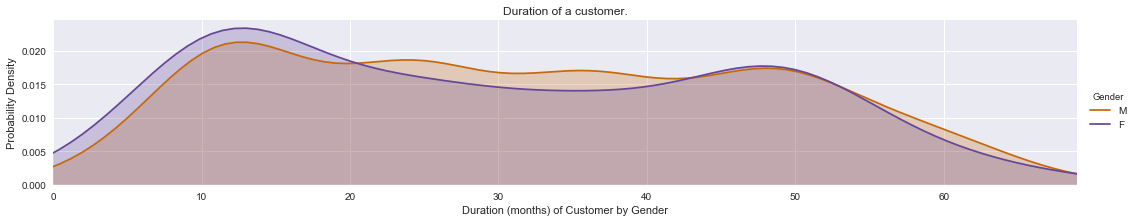

In [13]:
# Visualize the duration of a customer feature to the gender
facet = sns.FacetGrid(dataset, hue = 'Gender', aspect = 5)
facet.map(sns.kdeplot, 'DurationAsCust', shade = True)
facet.set(xlim = (0, dataset['DurationAsCust'].max()))
facet.add_legend()
plt.title('Duration of a customer.')
plt.ylabel('Probability Density')
plt.xlabel('Duration (months) of Customer by Gender')
plt.show()

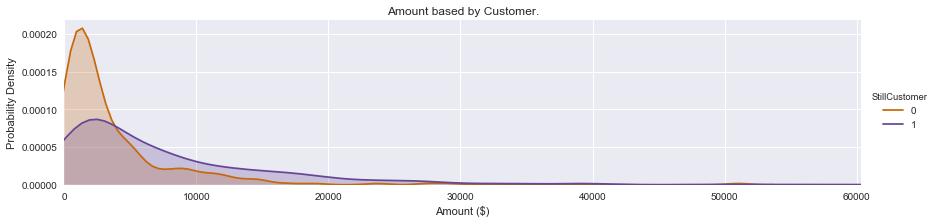

In [14]:
# Visualize the total amount feature to the label
facet = sns.FacetGrid(dataset, hue = 'StillCustomer', aspect = 4)
facet.map(sns.kdeplot, 'Total_Amount', shade = True)
facet.set(xlim = (0, dataset['Total_Amount'].max()))
facet.add_legend()
plt.title('Amount based by Customer.')
plt.ylabel('Probability Density')
plt.xlabel('Amount ($)')
plt.show()

# 4. Transform & Compare Models in PyCaret

In [15]:
dataset.columns

Index(['Customer_ID', 'Gender', 'Referrer', 'State', 'PaidFullPremiumBefore',
       'BecameCust', 'DurationAsCust', 'Accident/Health_(P)_Duration',
       'Accident/Health_(P)_Amount', 'Builders_Risk_(P)_Duration',
       'Builders_Risk_(P)_Amount', 'Dwelling_Fire_Duration',
       'Dwelling_Fire_Amount', 'Earthquake_(P)_Duration',
       'Earthquake_(P)_Amount', 'Flood_Duration', 'Flood_Amount',
       'Homeowners_Duration', 'Homeowners_Amount', 'Life_(P)_Duration',
       'Life_(P)_Amount', 'Motorcycle_Duration', 'Motorcycle_Amount',
       'Private_Passenger_Auto_Duration', 'Private_Passenger_Auto_Amount',
       'Umbrella_(P)_Duration', 'Umbrella_(P)_Amount', 'Total_Duration',
       'Total_Amount', 'StillCustomer'],
      dtype='object')

In [16]:
# Transform dataset (transform, bin and create dummy variables) and split. Note that we will 
# create a split of 95% (Train) and 5% (Test). The Test set will actually be our unseen holdout
# set for us to do our final validation. 

dl_cust_class = setup(data=dataset, target='StillCustomer', session_id=786, transformation=True, normalize=False, train_size=0.95, numeric_features=('Accident/Health_(P)_Duration', 'Accident/Health_(P)_Amount', 'Builders_Risk_(P)_Duration', 'Builders_Risk_(P)_Amount', 'Dwelling_Fire_Duration', 'Dwelling_Fire_Amount', 'Earthquake_(P)_Duration', 'Earthquake_(P)_Amount', 'Flood_Duration', 'Flood_Amount', 'Homeowners_Duration', 'Homeowners_Amount', 'Life_(P)_Duration', 'Life_(P)_Amount', 'Motorcycle_Duration', 'Motorcycle_Amount', 'Private_Passenger_Auto_Duration', 'Private_Passenger_Auto_Amount', 'Umbrella_(P)_Duration', 'Umbrella_(P)_Amount'), remove_outliers=False, outliers_threshold=0.05, remove_multicollinearity=False, multicollinearity_threshold=0.9, feature_selection=False, bin_numeric_features=['DurationAsCust'], feature_interaction=False, silent=True, ignore_features=['Customer_ID', 'BecameCust'])


Setup Succesfully Completed!


,Description,Value
0,session_id,786
1,Target Type,Binary
2,Label Encoded,None
3,Original Data,"(713, 30)"
4,Missing Values,False
5,Numeric Features,24
6,Categorical Features,5
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


In [17]:
# Allocateed various splits to appropriate variables
X_train = dl_cust_class[2]
y_train = dl_cust_class[4]
X_test = dl_cust_class[3]
y_test = dl_cust_class[5]

# Print shape of various splits
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train (677, 41)
y_train (677,)
X_test (36, 41)
y_test (36,)


In [18]:
# Compare various classification models in Pycaret. Create a top model and tune it in Pycaret.
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,Logistic Regression,0.7356,0.8028,0.8305,0.7683,0.797,0.4175
1,Extreme Gradient Boosting,0.7282,0.8031,0.8164,0.769,0.7903,0.403
2,CatBoost Classifier,0.7268,0.7943,0.8095,0.7698,0.7871,0.4042
3,Ridge Classifier,0.7267,0,0.8422,0.7527,0.7937,0.39
4,Gradient Boosting Classifier,0.7253,0.7961,0.8212,0.7611,0.789,0.3956
5,Linear Discriminant Analysis,0.7222,0.7975,0.8163,0.7601,0.7845,0.391
6,Ada Boost Classifier,0.7119,0.7758,0.8024,0.7567,0.7771,0.3683
7,K Neighbors Classifier,0.7089,0.7472,0.8189,0.7473,0.7794,0.3521
8,Light Gradient Boosting Machine,0.7076,0.7726,0.7906,0.7564,0.7708,0.3639
9,Random Forest Classifier,0.7062,0.7645,0.7768,0.7608,0.7668,0.3678


In [19]:
# Create the top model (Logistic Regression) with default settings
lr = create_model('lr')

,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,0.7500,0.8553,0.8095,0.7907,0.8000,0.4668
1,0.6912,0.8068,0.7381,0.7561,0.7470,0.3509
2,0.7941,0.8344,0.8605,0.8222,0.8409,0.5497
3,0.6912,0.7423,0.7674,0.7500,0.7586,0.3302
4,0.7647,0.7609,0.8837,0.7755,0.8261,0.4672
5,0.7059,0.8028,0.8140,0.7447,0.7778,0.3455
6,0.7500,0.8130,0.8605,0.7708,0.8132,0.4388
7,0.6418,0.6924,0.7381,0.7045,0.7209,0.2217
8,0.8209,0.8486,0.8810,0.8409,0.8605,0.6108
9,0.7463,0.8714,0.9524,0.7273,0.8247,0.3938


In [20]:
# Tune the top model (Logistic Regression) with default settings
tuned_dt = tune_model('lr')

,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,0.7500,0.8599,0.8095,0.7907,0.8000,0.4668
1,0.6912,0.8086,0.7381,0.7561,0.7470,0.3509
2,0.8088,0.8400,0.8837,0.8261,0.8539,0.5782
3,0.7059,0.7535,0.7674,0.7674,0.7674,0.3674
4,0.7647,0.7526,0.8837,0.7755,0.8261,0.4672
5,0.7206,0.8028,0.8140,0.7609,0.7865,0.3836
6,0.7500,0.8112,0.8605,0.7708,0.8132,0.4388
7,0.6418,0.6943,0.7381,0.7045,0.7209,0.2217
8,0.8060,0.8457,0.8810,0.8222,0.8506,0.5749
9,0.7463,0.8714,0.9524,0.7273,0.8247,0.3938


 # 5. Create a baseline single-layered neural network (NN) model

In [21]:
# Create a simple (blackbox) model for comparison to the Gaussian Process model.
model = Sequential()
model.add(Dense(units = 25, kernel_initializer = 'uniform', activation = 'relu', name = 'input_layer', input_dim=X_train.shape[1]))
model.add(Dense(units = 20, kernel_initializer = 'uniform', activation = 'relu', name='hidden_layer'))
model.add(Dense(units = 1, activation='sigmoid', name="output_layer"))
model.compile(optimizer = 'adam', loss='binary_crossentropy', metrics=["accuracy"])
model.summary()

# Define earlyStopping to limit epochs
earlyStopping = [keras.callbacks.EarlyStopping(monitor = 'val_loss', verbose=0), keras.callbacks.ModelCheckpoint(filepath = 'bestModel.hdf5', monitor = 'val_loss', save_best_only = True)]

# Fit the blackbox model.
blackbox = model.fit(X_train, y_train, batch_size=128, epochs=5, validation_split=.25, callbacks=earlyStopping, verbose=2)

# Evaluate the blackbox model and print accuracy
accuracy = model.evaluate(X_test,y_test)[1]
print("\n", "Accuracy Simple Neural Network Model:", accuracy, "\n")

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (Dense)          (None, 25)                1050      
_________________________________________________________________
hidden_layer (Dense)         (None, 20)                520       
_________________________________________________________________
output_layer (Dense)         (None, 1)                 21        
Total params: 1,591
Trainable params: 1,591
Non-trainable params: 0
_________________________________________________________________
Train on 507 samples, validate on 170 samples
Epoch 1/5
 - 1s - loss: 0.6921 - accuracy: 0.6312 - val_loss: 0.6899 - val_accuracy: 0.7176
Epoch 2/5
 - 0s - loss: 0.6884 - accuracy: 0.6765 - val_loss: 0.6866 - val_accuracy: 0.6353
Epoch 3/5
 - 0s - loss: 0.6847 - accuracy: 0.6509 - val_loss: 0.6823 - val_accuracy: 0.6353
Epoch 4/5
 - 0s - loss: 0.6800 - accuracy: 0.6667 - val_loss

# 6. Define Bayesian Optimization Gaussian Process

In [42]:
# Clear the Keras session to ensure it does not add the model to the same tensorflow graphy.
K.clear_session()
tensorflow.compat.v1.get_default_graph()
tensorflow.compat.v1.reset_default_graph()
tensorflow.keras.backend.clear_session()

# Declare and instantiate variables
COUNT = 0
time_list = []

# Enable class weights if you have a unbalanced dataset
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
class_weights = dict(enumerate(class_weights))

# Create search parameters using "dim_" short for dimension. The search will take place across nearly every parameter in the keras model. This will include: Number of Layers, Number of Nodes per layer, Learning Rate & Weight Decay for the Adam Optimizer, activation functions, batch size and Dropout rate.
dim_learning_rate = Real(low=1e-4, high=1e-2, prior='log-uniform', name='learning_rate')
dim_num_dense_layers = Integer(low=1, high=5, name='num_dense_layers')
dim_num_input_nodes = Integer(low=1, high=512, name='num_input_nodes')
dim_num_dense_nodes = Integer(low=1, high=512, name='num_dense_nodes')
dim_activation = Categorical(categories=['relu', 'sigmoid', 'tanh', 'selu', 'elu'], name='activation')
dim_batch_size = Integer(low=1, high=256, name='batch_size')
dim_adam_decay = Real(low=1e-6,high=1e-2, prior='uniform', name="adam_decay")
dim_dropout_rate = Real(low=0.0,high=0.5, prior='uniform', name="dropout_rate")

# Establish the variables in the deminsions variable.
dimensions = [dim_learning_rate,
              dim_num_dense_layers,
              dim_num_input_nodes,
              dim_num_dense_nodes,
              dim_activation,
              dim_batch_size,
              dim_adam_decay,
              dim_dropout_rate
             ]

In [43]:
# Declare the initial value for each variable.
default_parameters = [1e-3, 1, 512, 13, 'relu', 64, 1e-3, 0.1]

In [44]:
# Define the create_model to go through various combinations of parameters.
def create_model(learning_rate, num_dense_layers, num_input_nodes, num_dense_nodes, activation, adam_decay, dropout_rate):
    # Start the model creation process. 
    model = Sequential()
    model.add(Dense(num_input_nodes,
                    input_dim=X_train.shape[1],
                    activation=activation
                   ))
    model.add(Dropout(dropout_rate))
    
    # Create a loop making a new dense layer for the amount passed to this model.
    # Name the layers to help avoid tensorflow error deep in the stack trace.
    for i in range(num_dense_layers):
        name = 'layer_dense_{0}'.format(i+1)
        model.add(Dense(num_dense_nodes,
                 activation=activation,
                 name=name
                 ))
        model.add(Dropout(dropout_rate))
        
    # Add our classification layer.
    model.add(Dense(1,activation='sigmoid'))
    
    # Setup the optimizer and compile.
    adam = Adam(lr=learning_rate, decay=adam_decay)
    model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [25]:
# Define the arguments for the dimensions including earlyStopping for epochs.
@use_named_args(dimensions=dimensions)
def fitness(learning_rate, num_dense_layers, num_input_nodes, num_dense_nodes, activation, batch_size, adam_decay, dropout_rate):

    # Create a model template.            
    model = create_model(learning_rate=learning_rate,
                         num_dense_layers=num_dense_layers,
                         num_input_nodes=num_input_nodes,
                         num_dense_nodes=num_dense_nodes,
                         activation=activation,
                         adam_decay=adam_decay,
                         dropout_rate=dropout_rate
                        )
    
    # Define earlyStopping to limit epochs.
    earlyStopping = [keras.callbacks.EarlyStopping(monitor = 'val_loss', verbose=0), keras.callbacks.ModelCheckpoint(filepath = 'bestModel.hdf5', monitor = 'val_loss', save_best_only = True)]

    # Initiate start time to track duration of each model.
    start = time.time()

    # Set random seet for tensorflow model.
    tensorflow.random.set_seed(786)

    # Establish a blackbox model to fit. Note: verbose is set to 0 to limit memory consumption when executing search.
    blackbox = model.fit(x=X_train,
                        y=y_train,
                        epochs=50,
                        batch_size=batch_size,
                        validation_split=0.25,
                        callbacks=earlyStopping,
                        class_weight=class_weights,
                        shuffle=False,
                        verbose=0
                        )
    # Returns the validation accuracy for the last epoch.
    accuracy = blackbox.history['val_accuracy'][-1]

    # Capture end time for the duration of each model.
    end = time.time()

    # Define counter using COUNT variable.
    def increment():
        global COUNT
        COUNT = COUNT+1
    increment()

    # Define time_list to keep track of duration for each model.
    def time_list():
        global time_list
        time_list.append(end-start)
    time_list()

    # Print the n_call, duration and accuracy for each model.
    print("n_call:", COUNT)
    print("Time (seconds):", round((end - start),2))
    print("Accuracy: {0:.2%}".format(accuracy))
    print("")

    # Delete the Keras model with these hyper-parameters from memory.
    del model
    
    # Clear the Keras session to ensure it does not add the model to the same tensorflow graphy.
    K.clear_session()
    tensorflow.compat.v1.get_default_graph()
    tensorflow.compat.v1.reset_default_graph()
    tensorflow.keras.backend.clear_session()

    return - accuracy

# 7. Execute Bayesian Optimization Search

In [45]:
# Clear the Keras session to ensure it does not add the model to the same tensorflow graphy.
K.clear_session()
tensorflow.compat.v1.get_default_graph()
tensorflow.compat.v1.reset_default_graph()
tensorflow.keras.backend.clear_session()

In [46]:
# Execute the Bayesian optimization using Gaussian Processes.
gp_result = gp_minimize(func=fitness,
                            dimensions = dimensions,
                            n_calls = 75,
                            #noise = 'guassian',
                            n_jobs = -1,
                            kappa = 2.96,
                            random_state = 786,
                            acq_func = 'EI', # Expected Improvement.
                            x0 = default_parameters)

# Dump model into a pickle file for future reference. 
# dump(gp_result, 'gp_result.pkl')

n_call: 1
Time (seconds): 2.34
Accuracy: 77.06%

n_call: 2
Time (seconds): 2.36
Accuracy: 61.18%

n_call: 3
Time (seconds): 3.54
Accuracy: 38.82%

n_call: 4
Time (seconds): 4.81
Accuracy: 64.12%

n_call: 5
Time (seconds): 4.58
Accuracy: 77.65%

n_call: 6
Time (seconds): 3.46
Accuracy: 67.06%

n_call: 7
Time (seconds): 1.83
Accuracy: 61.18%

n_call: 8
Time (seconds): 4.46
Accuracy: 71.18%

n_call: 9
Time (seconds): 3.62
Accuracy: 54.12%

n_call: 10
Time (seconds): 9.9
Accuracy: 75.88%

n_call: 11
Time (seconds): 4.2
Accuracy: 77.06%



In [28]:
# Print the accuary of the best model.
print("Best Model Accuracy: " + str(round(gp_result.fun * -100, 2)) + "%.")

Best Model Accuracy: 79.41%.


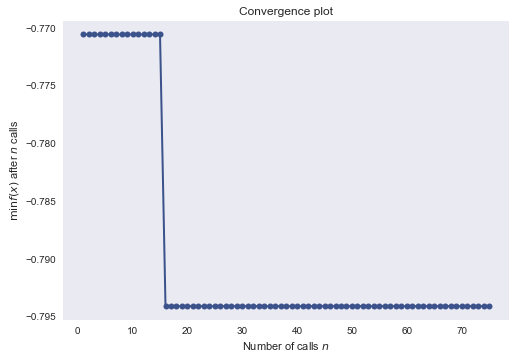

In [29]:
# Plot SKOPT convergence traces.
_ = plot_convergence(gp_result)

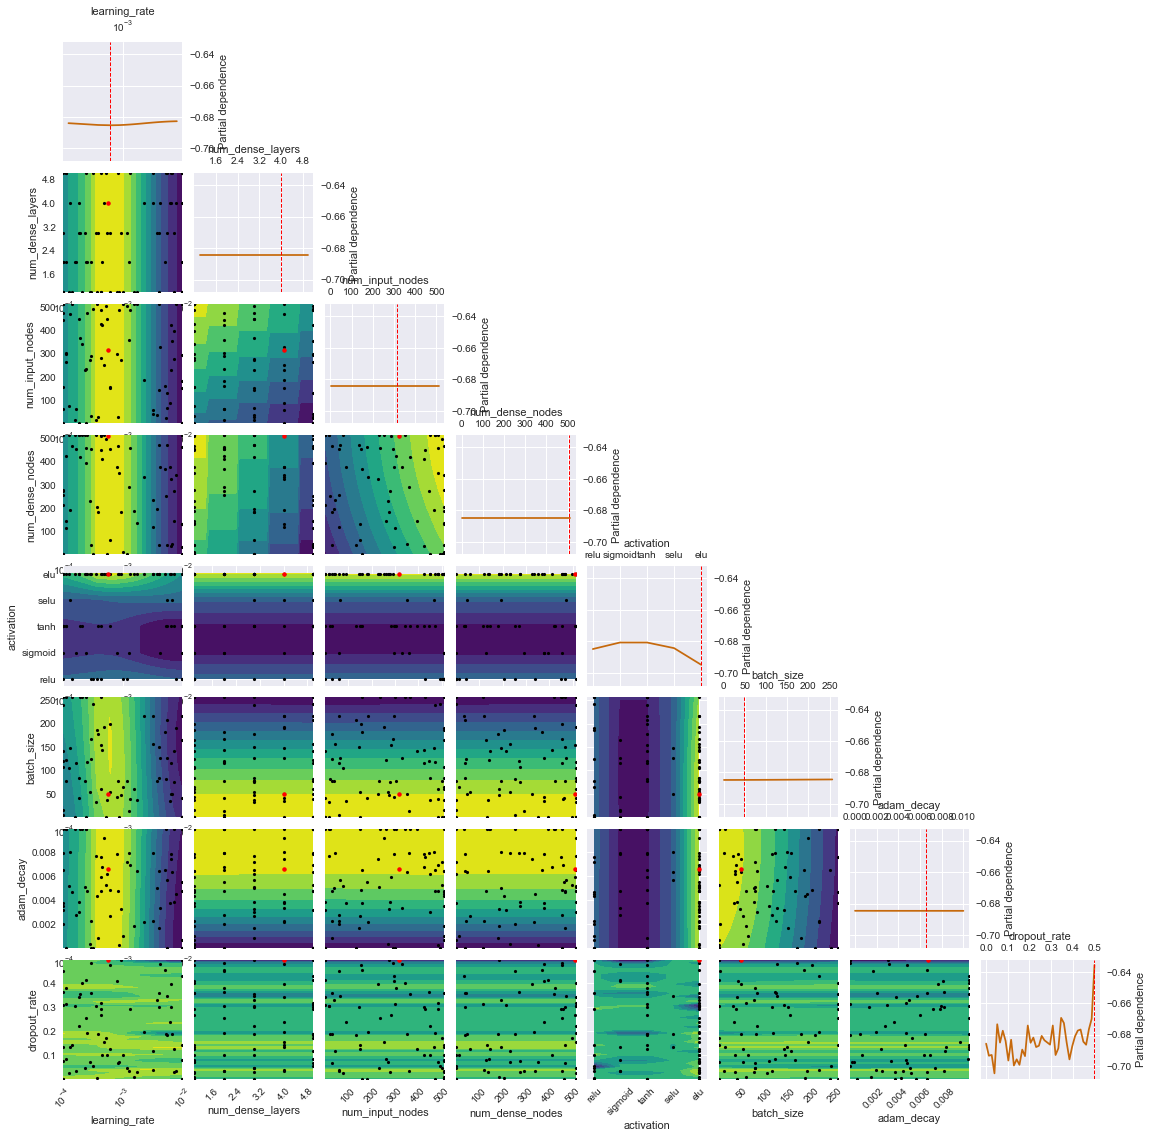

In [30]:
# Show pairwise dependence plot of the objective function.
_ = plot_objective(gp_result)

In [31]:
# Create a dataframe of the results.
df_gp_result = pd.concat([pd.DataFrame(gp_result.x_iters, 
                    columns = ["learning rate",
                    "hidden layers","input layer nodes","hidden layer nodes", "activation function","batch size", "adam learning rate decay","dropout rate"]),
                    (pd.Series(gp_result.func_vals*-100, name="accuracy"))], axis=1)

# Add duration of each model into the dataframe.
time_list = pd.DataFrame(time_list)

# Round the duration of each model.
df_gp_result['time (seconds)'] = round(time_list,2)

# Sort the models by accuracy (descending order).
df_gp_result_saved = df_gp_result.sort_values(by='accuracy', ascending=False)

In [32]:
# Display the top 5 most accurate models
df_gp_result_saved.head(5)

,learning rate,hidden layers,input layer nodes,hidden layer nodes,activation function,batch size,adam learning rate decay,dropout rate,accuracy,time (seconds)
15,0.000577,4,316,509,elu,49,0.006591,0.500000,79.411763,4.77
53,0.000490,4,251,512,elu,192,0.009228,0.152597,77.647060,3.53
0,0.001000,1,512,13,relu,64,0.001000,0.100000,77.058822,2.80
4,0.006148,4,88,377,elu,35,0.003747,0.236619,77.058822,6.43
58,0.000607,3,152,61,elu,53,0.002649,0.122951,77.058822,4.10


In [58]:
# Save and read data into a CSV file for future reference.
# df_gp_result_saved.to_csv('df_gp_result_saved.csv', index=True, index_label='index', header=True)

# Load the df_gp_result_saved.csv if returning.
# df_gp_result_saved = pd.read_csv('df_gp_result_saved.csv', index_col=0, header=0)

# 8. Create the selected Deep Learning model & validate

In [33]:
# Identify the best model (index number) that meets our criteria and input the index number from df_gp_result_saved.
gp_model_parameters = gp_result.x_iters[15]
df_gp_result_saved.loc[[15]]

,learning rate,hidden layers,input layer nodes,hidden layer nodes,activation function,batch size,adam learning rate decay,dropout rate,accuracy,time (seconds)
15,0.000577,4,316,509,elu,49,0.006591,0.5,79.411763,4.77


In [36]:
# Clear the Keras session to ensure it does not add the model to the same tensorflow graphy.
K.clear_session()
tensorflow.compat.v1.get_default_graph()
tensorflow.compat.v1.reset_default_graph()
tensorflow.keras.backend.clear_session()

# Create a model based on the best model we have selected.
gp_model = create_model(gp_model_parameters[0],  gp_model_parameters[1], 
                        gp_model_parameters[2], gp_model_parameters[3], 
                        gp_model_parameters[4], gp_model_parameters[5], 
                        gp_model_parameters[6])

# Display our final model. 
gp_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 316)               13272     
_________________________________________________________________
dropout_1 (Dropout)          (None, 316)               0         
_________________________________________________________________
layer_dense_1 (Dense)        (None, 509)               161353    
_________________________________________________________________
dropout_2 (Dropout)          (None, 509)               0         
_________________________________________________________________
layer_dense_2 (Dense)        (None, 509)               259590    
_________________________________________________________________
dropout_3 (Dropout)          (None, 509)               0         
_________________________________________________________________
layer_dense_3 (Dense)        (None, 509)              

In [37]:
# Select optimizer then compile and fit the selected model.
adam = Adam(lr=gp_model_parameters[0], decay=gp_model_parameters[6])
gp_model.compile(optimizer=adam, loss='binary_crossentropy',
                 metrics=['accuracy'])

# Create earlyStopping call back.
earlyStopping = [keras.callbacks.EarlyStopping(monitor='val_loss', verbose=0), 
                 keras.callbacks.ModelCheckpoint(filepath='bestModel.hdf5', 
                                                 monitor='val_loss', save_best_only=True)]

# Fit the model using the best selected parameters.
history = gp_model.fit(X_train, y_train, 
                       validation_data=(X_test, y_test), 
                       epochs=20, 
                       callbacks=earlyStopping, 
                       batch_size=gp_model_parameters[5], 
                       verbose=2)

Train on 677 samples, validate on 36 samples
Epoch 1/20
 - 2s - loss: 0.6082 - accuracy: 0.6544 - val_loss: 0.5132 - val_accuracy: 0.7778
Epoch 2/20
 - 0s - loss: 0.5543 - accuracy: 0.7179 - val_loss: 0.5080 - val_accuracy: 0.7778
Epoch 3/20
 - 0s - loss: 0.5169 - accuracy: 0.7459 - val_loss: 0.4799 - val_accuracy: 0.7222
Epoch 4/20
 - 0s - loss: 0.5174 - accuracy: 0.7297 - val_loss: 0.4357 - val_accuracy: 0.8056
Epoch 5/20
 - 0s - loss: 0.5094 - accuracy: 0.7341 - val_loss: 0.5022 - val_accuracy: 0.7778


In [38]:
# Evaluate the selected model.
_, train_acc = gp_model.evaluate(X_train, y_train, verbose=0)
_, test_acc = gp_model.evaluate(X_test, y_test, verbose=0)

print("\n", 'Train: %.3f, Test: %.3f' % (train_acc, test_acc), "\n")


 Train: 0.753, Test: 0.778 



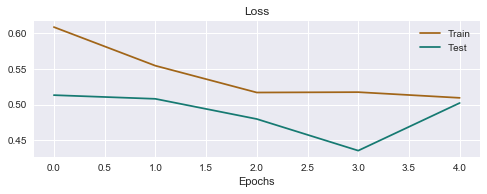

In [39]:
# Plot Loss during training on selected model.
plt.subplot(211)
plt.title('Loss')
plt.plot(history.history['loss'], label='Train', color='#a16518')
plt.plot(history.history['val_loss'], label='Test', color='#167a72')
plt.xlabel('Epochs')
plt.legend()
plt.show()

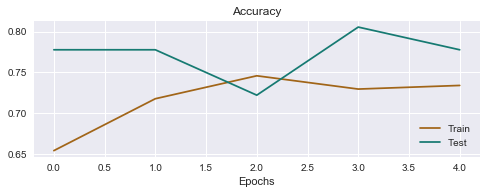

In [40]:
# Plot Accuracy during training on selected model.
plt.subplot(212)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='Train', color='#a16518')
plt.plot(history.history['val_accuracy'], label='Test', color='#167a72')
plt.xlabel('Epochs')
plt.legend()
plt.show()

[Text(0, 0.5, 'Still Customer'), Text(0, 1.5, 'Not Customer')]

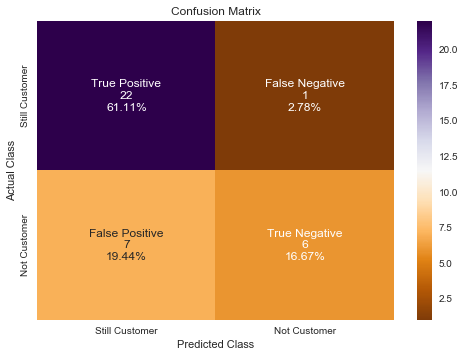

In [41]:
# Create Confusion Matrix for Visualization

# Create classes to compare
y_pred_classes = gp_model.predict_classes(X_test)
y_pred_probs = gp_model.predict(X_test)

# Create a confusion matrix for us to visualize
cf_matrix = confusion_matrix(y_test, y_pred_classes, labels=[1, 0])

# Modify the names and create counts and percentages 
group_names = ['True Positive', 'False Negative', 'False Positive', 'True Negative']
group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2,2)

# Visualize the heatmap (confusion matrix)
ax = plt.subplot()
plt.rcParams["axes.labelsize"] = 12
plt.rcParams.update({'font.size': 12})
sns.heatmap(cf_matrix, annot=labels, fmt='', ax=ax, annot_kws={'fontsize':12}, cmap='PuOr')

# labels, title and ticks
ax.set_xlabel('Predicted Class')
ax.set_ylabel('Actual Class')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Still Customer', 'Not Customer'])
ax.yaxis.set_ticklabels(['Still Customer', 'Not Customer'], va='center')

# 9. Sources and References

Scikit Learn: Learn: Machine learning in Python - scikit-learn 0.16.1 documentation. (n.d.). Retrieved June 11, 2020, from https://scikit-learn.org/

Pycaret. (2020, May 11). Retrieved June 11, 2020, from https://pycaret.org/

TensorFlow. (n.d.). Retrieved June 12, 2020, from https://www.tensorflow.org/

Team, K. (n.d.). Simple. Flexible. Powerful. Retrieved June 12, 2020, from https://keras.io/

Scikit Learn Optimize. (n.d.). Retrieved June 12, 2020, from https://scikit-optimize.github.io/stable/index.html